## Exercise-1: Training Deep Neural Network on MNIST
### Q1.1 Report the obtained test accuracy.
We start by importing the necessary libraries and setting random seeds to 42 for reproducibility. If the device is running on Apple Silicon, we use Metal Performance Shaders (MPS) to speed up training.

In [368]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import random
import copy 


# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Use Metal Performance Shaders (MPS) GPU if available on Apple Silicon
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: mps


Next, we load the MNIST dataset and apply standard transforms to preprocess the images.

In [369]:
# Define transforms for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST standardization
])

# Import MNIST dataset
mnist_full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_full_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

We use a small subset of MNIST, taking the first 1000 training samples and 200 test samples. We then split the training subset into training and validation sets. Finally, we create DataLoaders with a batch size of 32 to handle batching during training and evaluation.

In [370]:
# Restrict to small subset for controlled experiment
mnist_temp_dataset = Subset(mnist_full_train, range(1000))  # use only first 1000 train samples
mnist_test_dataset  = Subset(mnist_full_test, range(200))   # use first 200 test samples

# This ensures that random_split produces the same train/val split every run
generator = torch.Generator().manual_seed(seed)
mnist_train_dataset, mnist_val_dataset = random_split(mnist_temp_dataset, [800, 200], generator=generator)

# Create DataLoaders for batching
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=32, shuffle=True)
mnist_val_loader   = DataLoader(mnist_val_dataset, batch_size=32, shuffle=False)
mnist_test_loader  = DataLoader(mnist_test_dataset, batch_size=32, shuffle=False)

We define a custom DNN by creating a class that extends `nn.Module`. It has three hidden layers with 64 neurons each, uses ELU activations, and outputs 10 neurons for the 10 MNIST classes. He normal initialization is applied to all linear layers for better convergence.

In [371]:
class MNIST_DNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),        
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )

        # Apply He normal initialization to all Linear layers
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

We create a `train_model()` function to handle training and validation. It tracks losses and accuracies, uses global device/optimizer/criterion, and implements early stopping to keep the best model weights.

In [372]:
def train_model(model, train_loader, val_loader, epochs, patience):  
    global device
    global optimizer
    global criterion

    best_val_loss = float('inf')
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * X_batch.size(0)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----- Validation -----
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                running_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total

        # ----- Save metrics -----
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        # ----- Early stopping -----
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

We now train the model using the Nadam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss. Early stopping monitors the validation loss with a patience of 5 epochs and restores the best weights. Training runs for up to 50 epochs.

In [373]:
model = MNIST_DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 50
patience = 5  # for early stopping

model, history = train_model(model, mnist_train_loader, mnist_val_loader, epochs, patience)

Epoch 1/50 | Train Loss: 1.5316, Acc: 0.5200 | Val Loss: 0.8568, Acc: 0.7250
Epoch 2/50 | Train Loss: 0.5479, Acc: 0.8438 | Val Loss: 0.6026, Acc: 0.8100
Epoch 3/50 | Train Loss: 0.2914, Acc: 0.9175 | Val Loss: 0.5422, Acc: 0.8450
Epoch 4/50 | Train Loss: 0.1792, Acc: 0.9463 | Val Loss: 0.5029, Acc: 0.8500
Epoch 5/50 | Train Loss: 0.1108, Acc: 0.9738 | Val Loss: 0.5408, Acc: 0.8400
Epoch 6/50 | Train Loss: 0.0633, Acc: 0.9912 | Val Loss: 0.5163, Acc: 0.8500
Epoch 7/50 | Train Loss: 0.0402, Acc: 0.9975 | Val Loss: 0.5215, Acc: 0.8600
Epoch 8/50 | Train Loss: 0.0262, Acc: 1.0000 | Val Loss: 0.5276, Acc: 0.8600
Epoch 9/50 | Train Loss: 0.0190, Acc: 1.0000 | Val Loss: 0.5326, Acc: 0.8700
Early stopping triggered after 9 epochs.


We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

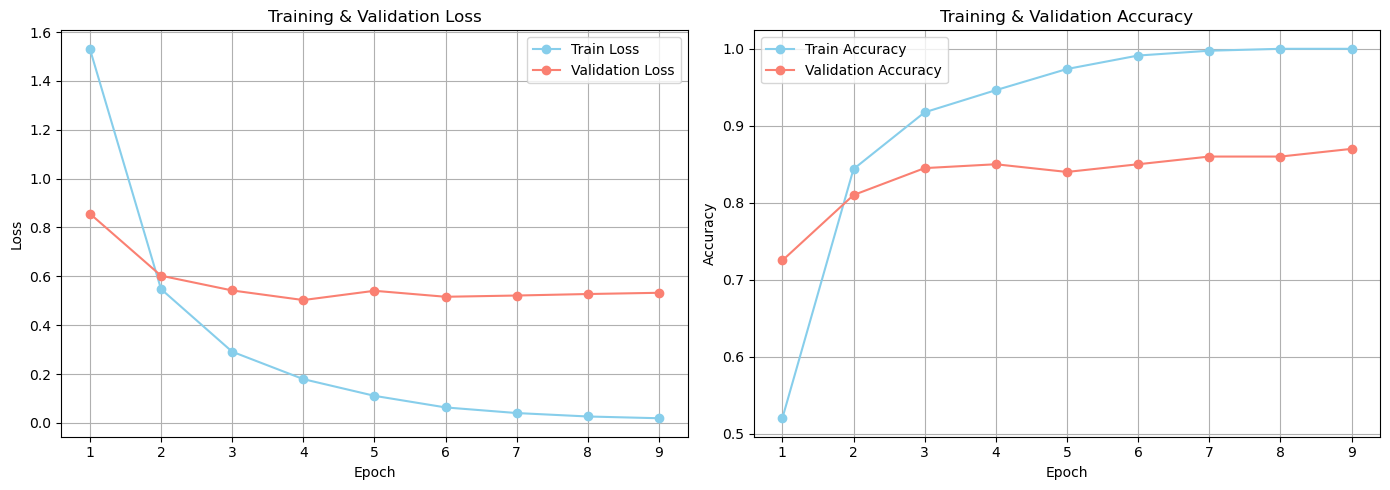

In [374]:
def plotAccuracyAndLoss(history):

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)  # Start from epoch 1

    # ----- Left subplot: Loss -----
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='skyblue', marker='o')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='salmon', marker='o')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    # ----- Right subplot: Accuracy -----
    ax[1].plot(epochs, history['train_acc'], label='Train Accuracy', color='skyblue', marker='o')
    ax[1].plot(epochs, history['val_acc'], label='Validation Accuracy', color='salmon', marker='o')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plotAccuracyAndLoss(history)

Upon analyzing the trends, we can observe that the validation accuracy stops improving meaningfully after epoch 4. This is expected, as we are training and validating on a small subset of the MNIST dataset. With such a limited dataset, the model might not be able to generalize well beyond the training data, which can lead to a plateau in performance.

In [375]:
def evaluateWithTestSet(model, test_loader):
    global device
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = (correct / total)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluate the test accuracy
evaluateWithTestSet(model, mnist_test_loader)

Test Accuracy: 87.50%


The model achieves a test accuracy of 87.5%. This shows that the DNN captures some patterns in the data, but performance could likely improve with a larger dataset, as training plateaus quickly.

## Exercise-2: Training Deep Neural Network on CIFAR-10
### Q2.1 Report the obtained test accuracy.
We start by loading the CIFAR-10 dataset and apply standard transforms to preprocess the images.

In [376]:
transform = transforms.Compose([
    transforms.ToTensor(),   # convert to [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean for CIFAR-10
                         (0.2023, 0.1994, 0.2010))  # std for CIFAR-10
])

cifar_full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_full_test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

We use a small subset of CIFAR-10, taking the first 5000 training samples and 1000 test samples. We then split the training subset into training and validation sets. Finally, we create DataLoaders with a batch size of 128 to handle batching during training and evaluation.

In [377]:
# Restrict to small subset for controlled experiment
cifar_temp_dataset = Subset(cifar_full_train, range(5000))  # use only first 5000 train samples
cifar_test_dataset  = Subset(cifar_full_test, range(1000))   # use first 1000 test samples

# This ensures that random_split produces the same train/val split every run
cifar_train_dataset, cifar_val_dataset = random_split(cifar_temp_dataset, [4000, 1000], generator=generator)

# Create DataLoaders for batching
cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=128, shuffle=True)
cifar_val_loader   = DataLoader(cifar_val_dataset, batch_size=128, shuffle=False)
cifar_test_loader  = DataLoader(cifar_test_dataset, batch_size=128, shuffle=False)

We define a custom DNN by creating a class that extends `nn.Module`. It has 4 hidden layers with 256 neurons each, uses ELU activations, and outputs 10 neurons for the 10 CIFAR-10 classes. He normal initialization is applied to all linear layers for better convergence.

In [378]:
class CIFAR10_DNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),        
            nn.Linear(32*32*3, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 10)
        )   

        # Apply He normal initialization to all Linear layers
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

We now train the model using the Nadam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss. Early stopping monitors the validation loss with a patience of 5 epochs and restores the best weights. Training runs for up to 50 epochs.

In [379]:
model = CIFAR10_DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 50
patience = 5  # for early stopping

model, history = train_model(model, cifar_train_loader, cifar_val_loader, epochs, patience)

Epoch 1/50 | Train Loss: 2.9551, Acc: 0.2677 | Val Loss: 2.8236, Acc: 0.2830
Epoch 2/50 | Train Loss: 1.6629, Acc: 0.4475 | Val Loss: 2.4223, Acc: 0.3170
Epoch 3/50 | Train Loss: 1.1999, Acc: 0.5982 | Val Loss: 3.0388, Acc: 0.2790
Epoch 4/50 | Train Loss: 0.9879, Acc: 0.6853 | Val Loss: 2.4644, Acc: 0.3130
Epoch 5/50 | Train Loss: 0.6784, Acc: 0.7820 | Val Loss: 3.1131, Acc: 0.3240
Epoch 6/50 | Train Loss: 0.5859, Acc: 0.8207 | Val Loss: 2.7715, Acc: 0.3100
Epoch 7/50 | Train Loss: 0.4050, Acc: 0.8792 | Val Loss: 2.6296, Acc: 0.3470
Early stopping triggered after 7 epochs.


We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

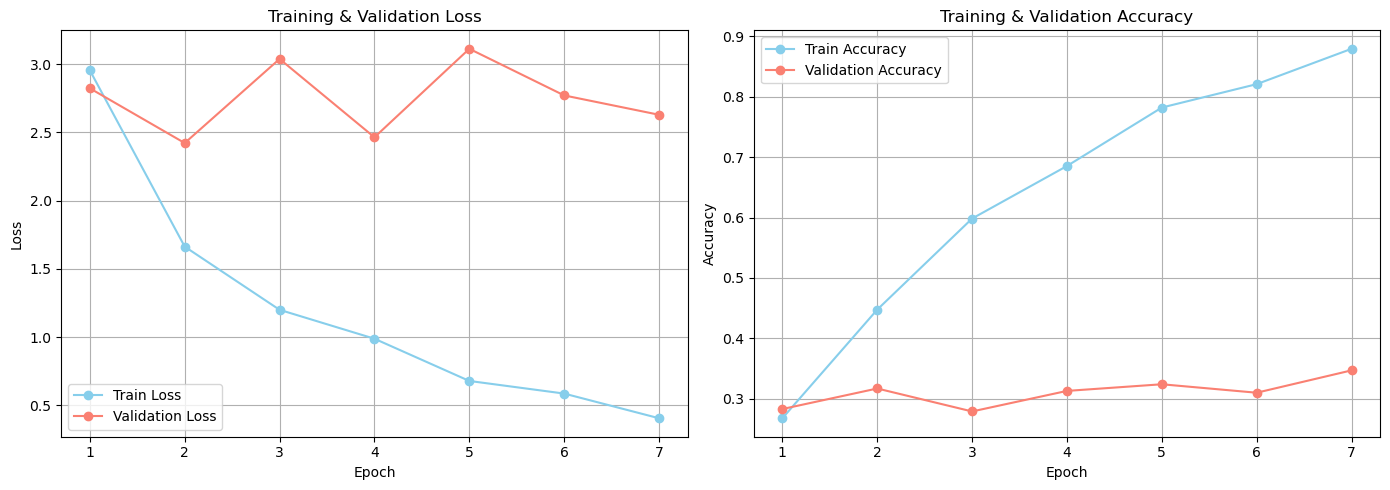

In [380]:
plotAccuracyAndLoss(history)

Upon analyzing the trends, the model demonstrates good performance on the training data over time. However, the validation loss and accuracy show signs of stagnation, indicating potential overfitting and insufficient generalization

In [381]:
# Evaluate the test accuracy
evaluateWithTestSet(model, cifar_test_loader)

Test Accuracy: 30.50%


The test accuracy is relatively low (~31%), suggesting that the model struggles to generalize well to unseen data. Despite the progress in training accuracy, the performance on the test data does not reflect a similar improvement. This indicates that the model is overfitting, and is likely due to the limited scale of the training data used.

## Exercise-3: Regularization with Alpha Dropout and MC Dropout
### Q3.1 Report the test accuracy of the network with Alpha Dropout applied during training.
We start by creating a custom LeCun normal initialization for our weights.

In [382]:
def lecun_normal_init(layer):

    if isinstance(layer, nn.Linear):
        # Calculate fan_in (the number of input units to the layer)
        fan_in = layer.weight.size(1)
        
        # Standard deviation for LeCun normal initialization
        std = (1.0 / fan_in) ** 0.5
        
        # Initialize the weights with normal distribution
        nn.init.normal_(layer.weight, mean=0, std=std)
        
        # Initialize the bias to zero
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

We define a custom DNN with Alpha Dropout regulization. It has 4 hidden layers with 256 neurons each, uses SELU activations, and outputs 10 neurons for the 10 MNIST classes. The LeCun normal initialization is applied to all linear layers for better convergence.

In [383]:
class MNIST_DNN_REG(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.SELU(),
            nn.AlphaDropout(dropout_rate),
            
            nn.Linear(64, 64),
            nn.SELU(),
            nn.AlphaDropout(dropout_rate),
            
            nn.Linear(64, 64),
            nn.SELU(),
            nn.AlphaDropout(dropout_rate),
            
            nn.Linear(64, 10)
        )

        # LeCun normal initialization
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                lecun_normal_init(layer)

    def forward(self, x):
        return self.model(x)

We now train the model using the Nadam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss. Early stopping monitors the validation loss with a patience of 5 epochs and restores the best weights. Training runs for up to 50 epochs.

In [384]:
model = MNIST_DNN_REG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 50
patience = 5  # for early stopping

model, history = train_model(model, mnist_train_loader, mnist_val_loader, epochs, patience)

Epoch 1/50 | Train Loss: 1.7629, Acc: 0.3837 | Val Loss: 0.7394, Acc: 0.7500
Epoch 2/50 | Train Loss: 0.9129, Acc: 0.6963 | Val Loss: 0.6011, Acc: 0.8150
Epoch 3/50 | Train Loss: 0.6738, Acc: 0.7725 | Val Loss: 0.6157, Acc: 0.8400
Epoch 4/50 | Train Loss: 0.5037, Acc: 0.8425 | Val Loss: 0.6077, Acc: 0.8500
Epoch 5/50 | Train Loss: 0.4236, Acc: 0.8725 | Val Loss: 0.6545, Acc: 0.8650
Epoch 6/50 | Train Loss: 0.3317, Acc: 0.9000 | Val Loss: 0.6560, Acc: 0.8650
Epoch 7/50 | Train Loss: 0.2982, Acc: 0.9075 | Val Loss: 0.6946, Acc: 0.8550
Early stopping triggered after 7 epochs.


We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

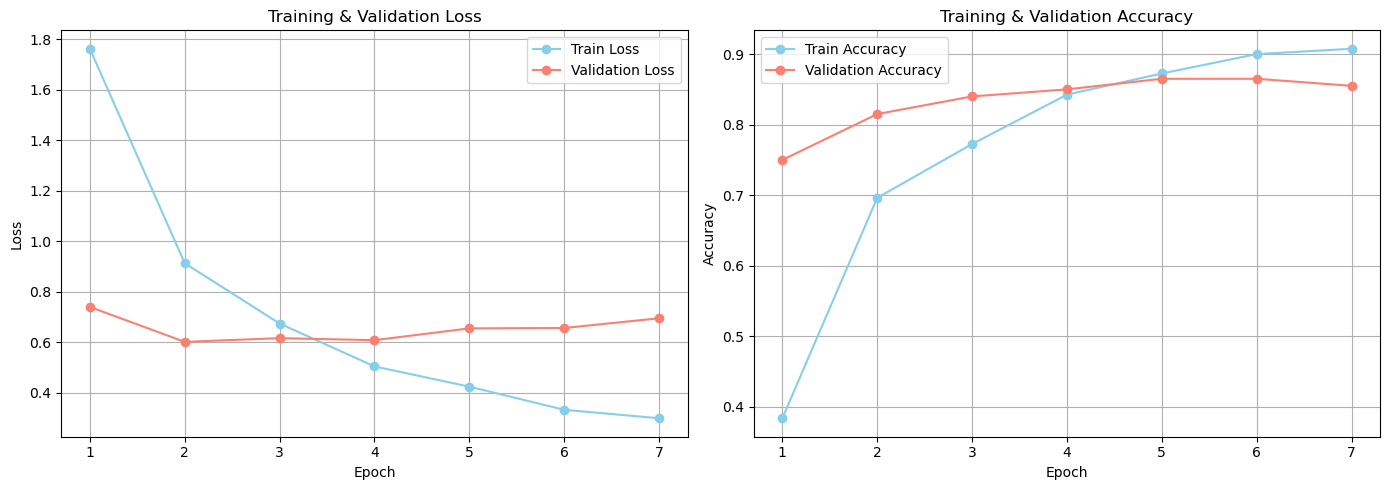

In [385]:
plotAccuracyAndLoss(history)

Upon analyzing the trends, the model’s validation loss and accuracy appear to plateau, showing little improvement after the initial epochs. This suggests that the model may be overfitting, likely due to the limited size of the dataset.

In [386]:
# Evaluate the test accuracy
evaluateWithTestSet(model, mnist_test_loader)

Test Accuracy: 78.50%


The test accuracy is consistent with the validation accuracy, indicating that the model generalizes well. However, there is still room for further improvement.

### Q3.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions)
Monte Carlo Dropout is used to enhance the model accuracy by simulating multiple iterations of dropout on the test set. We start by creating a function that simulates n-samples to compute the uncertainty and accuracy. 

In [387]:
def mcDropoutAccuracy(model, test_loader, n_samples=20):
    global device
    model.train()  # keep dropout active for MC sampling

    all_preds = []
    all_labels = []
    all_uncertainty = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            mc_outputs = []

            # Perform multiple stochastic forward passes
            for _ in range(n_samples):
                mc_outputs.append(model(X_batch))

            # Stack and average across samples
            mc_outputs = torch.stack(mc_outputs)
            preds_mean = mc_outputs.mean(dim=0)
            uncertainty = mc_outputs.var(dim=0)

            all_preds.append(preds_mean)
            all_labels.append(y_batch)
            all_uncertainty.append(uncertainty)

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_uncertainty = torch.cat(all_uncertainty)

    # Get predicted classes
    y_pred = torch.argmax(all_preds, dim=1)
    accuracy = (y_pred == all_labels).float().mean().item()

    print(f"Accuracy with Monte Carlo Dropout: {accuracy * 100:.2f}%")
    return accuracy, all_uncertainty

mc_acc, mc_var = mcDropoutAccuracy(model, mnist_test_loader, n_samples=20)

Accuracy with Monte Carlo Dropout: 78.50%


Using Monte Carlo Dropout with 20 stochastic samples resulted in an accuracy similar to the baseline. This minimal change is expected since AlphaDropout with SELU preserves self-normalization, reducing the variability that MC Dropout relies on to enhance predictions.

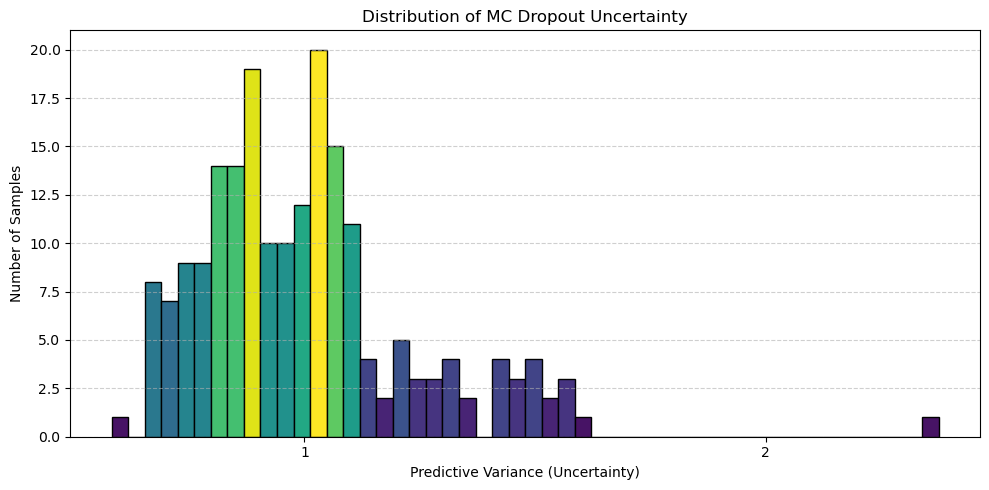

In [388]:
def plotMcUncertainty(mc_var):
    sample_uncertainty = mc_var.mean(dim=1)
    data = sample_uncertainty.cpu().numpy()

    plt.figure(figsize=(10,5))

    # Create histogram data without plotting directly to apply custom colors
    counts, bins, patches = plt.hist(data, bins=50, edgecolor='black')

    # Apply a colormap to the bars (gradient effect)
    # Normalize counts to [0,1] for colormap
    norm = plt.Normalize(counts.min(), counts.max())
    cmap = plt.cm.viridis

    for count, patch in zip(counts, patches):
        color = cmap(norm(count))
        patch.set_facecolor(color)

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add labels and title with better fonts
    plt.title("Distribution of MC Dropout Uncertainty")
    plt.xlabel("Predictive Variance (Uncertainty)")
    plt.ylabel("Number of Samples")

    # Format x-axis ticks to be integer-friendly
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

plotMcUncertainty(mc_var)

While Monte Carlo Dropout did not significantly improve accuracy, it provides insight into model confidence. The distribution of predictive variances shows that most samples exhibit uncertainty values around 1, suggesting that the model is generally confident in its predictions, with only a few samples displaying higher uncertainty.

## Exercise-4: Transfer Learning with Pre-trained CNN
### Q4.1 Report the test accuracy of the model.
We start by importing the pre-trained MobileNetV2 model, with weights initialized from the *ImageNet* dataset. All the pre-trained parameters are frozen to prevent updates during training. We then replace the original classifier head with a custom classifier tailored for our task.

In [389]:
# Import pre-traind CNN
mobilenet_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')

# Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Replace classifier with custom head
num_features = mobilenet_v2.last_channel  # number of features from conv layers
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)

model = mobilenet_v2.to(device)

Since MobileNetV2 expects input images of size 224x224, we resize the CIFAR-10 dataset images from their original 32x32 resolution to 224x224 during preprocessing.

In [ ]:
# Transform: scale, convert to tensor and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Scaled to match input shape of MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
cifar_scaled_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_scaled_test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

We use a small subset of CIFAR-10, taking the first 2000 training samples and 500 test samples. We then split the training subset into training and validation sets. Finally, we create DataLoaders with a batch size of 32 to handle batching during training and evaluation.

In [391]:
# Restrict to small subset for controlled experiment
cifar_temp_dataset = Subset(cifar_scaled_train, range(2000))  # use only first 2000 train samples
cifar_test_dataset = Subset(cifar_scaled_test, range(500))   # use first 500 test samples

# This ensures that random_split produces the same train/val split every run
cifar_train_dataset, cifar_val_dataset = random_split(cifar_temp_dataset, [1600, 400], generator=generator)

# Create DataLoaders for batching
cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=32, shuffle=True)
cifar_val_loader   = DataLoader(cifar_val_dataset, batch_size=32, shuffle=False)
cifar_test_loader  = DataLoader(cifar_test_dataset, batch_size=32, shuffle=False)

We now train the model using the Adam optimizer with a learning rate of 0.001, optimizing only the parameters of the custom classifier head. The loss function used is sparse categorical cross-entropy loss. Training is run for 5 epochs without early stopping.

In [392]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
patience = 5  # no early stopping

model, history = train_model(model, cifar_train_loader, cifar_val_loader, epochs, patience)

Epoch 1/5 | Train Loss: 1.7563, Acc: 0.3762 | Val Loss: 1.2289, Acc: 0.5650
Epoch 2/5 | Train Loss: 1.1254, Acc: 0.6138 | Val Loss: 0.9734, Acc: 0.6475
Epoch 3/5 | Train Loss: 0.9492, Acc: 0.6713 | Val Loss: 0.9147, Acc: 0.7200
Epoch 4/5 | Train Loss: 0.7993, Acc: 0.7275 | Val Loss: 0.9154, Acc: 0.6625
Epoch 5/5 | Train Loss: 0.7584, Acc: 0.7450 | Val Loss: 0.8577, Acc: 0.6750


We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

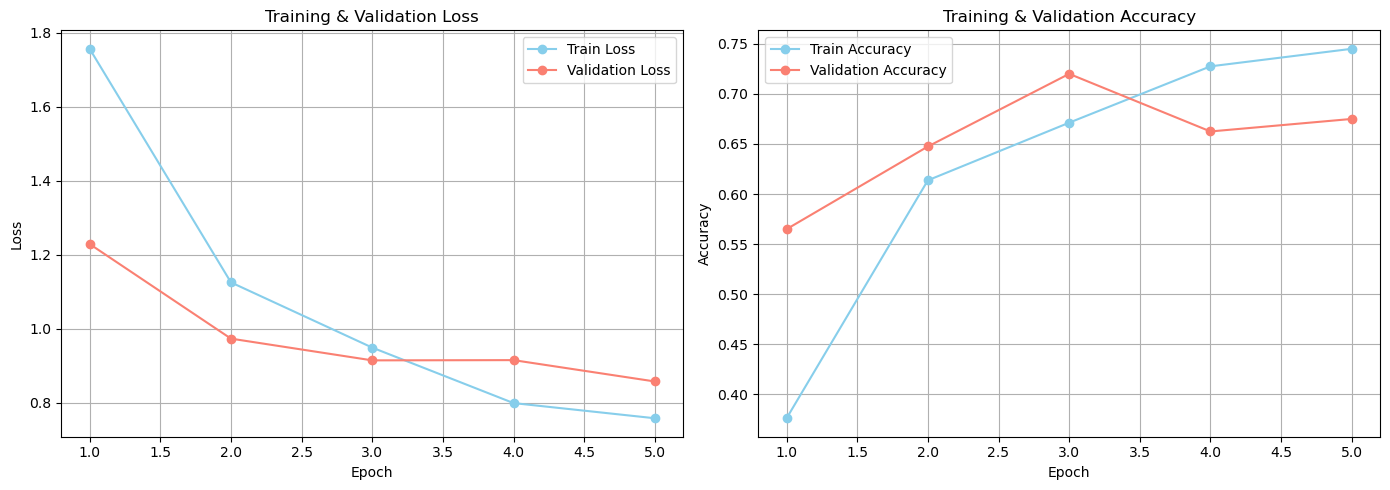

In [393]:
plotAccuracyAndLoss(history)

Upon analyzing the trends, the model performs well overall, showing consistent improvement in training accuracy and loss. However, there is a noticeable gap between training and validation performance, with the validation accuracy plateauing and validation loss fluctuating. This suggests the model is likely overfitting the training data and not fully generalizing to unseen data.

In [394]:
evaluateWithTestSet(model, cifar_test_loader)

Test Accuracy: 67.80%


The test accuracy of ~68% is a significant improvement compared to the previous model without transfer learning, which achieved ~31%. This demonstrates the effectiveness of leveraging pre-trained MobileNetV2 features for this task.

## Exercise-5: Deeper CNN Training on SVHN
### Q5.1 Report the test accuracy of the deeper CNN model.
We start by loading the SVHN dataset and apply standard transforms to preprocess the images.

In [395]:
# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # converts [0, 255] uint8 to [0.0, 1.0] float
    transforms.Normalize((0.4377, 0.4438, 0.4728),  # SVHN mean
                         (0.1980, 0.2010, 0.1970))  # SVHN std
])

# Load SVHN dataset
svhn_full_train = datasets.SVHN(root="./data", split='train', download=True, transform=transform)
svhn_full_test  = datasets.SVHN(root="./data", split='test', download=True, transform=transform)

We use a small subset of SVHN, taking the first 2000 training samples and 500 test samples. We then split the training subset into training and validation sets. Finally, we create DataLoaders with a batch size of 32 to handle batching during training and evaluation.

In [396]:
# Restrict to small subset for controlled experiment
svhn_temp_dataset = Subset(svhn_full_train, range(2000))  # use only first 2000 train samples
svhn_test_dataset = Subset(svhn_full_test, range(500))   # use first 500 test samples

# This ensures that random_split produces the same train/val split every run
svhn_train_dataset, svhn_val_dataset = random_split(svhn_temp_dataset, [1600, 400], generator=generator)

# Create DataLoaders for batching
svhn_train_loader = DataLoader(svhn_train_dataset, batch_size=32, shuffle=True)
svhn_val_loader   = DataLoader(svhn_val_dataset, batch_size=32, shuffle=False)
svhn_test_loader  = DataLoader(svhn_test_dataset, batch_size=32, shuffle=False)

We define a custom CNN for the SVHN dataset consisting of 4 convolutional layers with ReLU activations and 2 max-pooling layers for feature extraction. The flattened output is passed to a dense layer with 256 neurons and a dropout rate of 0.3 to reduce overfitting, followed by an output layer with 10 neurons representing the SVHN classes. He normal initialization is applied to all convolutional and linear layers to improve convergence and stability during training.

In [ ]:
class SVHN_CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )   

        # Apply He normal initialization to all Linear layers
        for layer in list(self.features) + list(self.classifier):
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.features(x)    
        x = self.classifier(x) 
        return x


We train the custom CNN model using the Adam optimizer with a learning rate of 0.001 and the cross-entropy loss function. The model is trained for 15 epochs without early stopping.

In [398]:
model = SVHN_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
patience = 15  # no early stopping

model, history = train_model(model, svhn_train_loader, svhn_val_loader, epochs, patience)

Epoch 1/15 | Train Loss: 2.4983, Acc: 0.1875 | Val Loss: 2.2098, Acc: 0.2000
Epoch 2/15 | Train Loss: 2.0121, Acc: 0.3019 | Val Loss: 1.7965, Acc: 0.4050
Epoch 3/15 | Train Loss: 1.4109, Acc: 0.5463 | Val Loss: 1.2037, Acc: 0.6250
Epoch 4/15 | Train Loss: 0.9003, Acc: 0.7106 | Val Loss: 0.9589, Acc: 0.7225
Epoch 5/15 | Train Loss: 0.6340, Acc: 0.7950 | Val Loss: 0.8696, Acc: 0.7375
Epoch 6/15 | Train Loss: 0.4298, Acc: 0.8625 | Val Loss: 0.8773, Acc: 0.7425
Epoch 7/15 | Train Loss: 0.3319, Acc: 0.8962 | Val Loss: 0.8985, Acc: 0.7725
Epoch 8/15 | Train Loss: 0.2728, Acc: 0.9113 | Val Loss: 0.9331, Acc: 0.7600
Epoch 9/15 | Train Loss: 0.1795, Acc: 0.9481 | Val Loss: 1.0752, Acc: 0.7850
Epoch 10/15 | Train Loss: 0.1635, Acc: 0.9437 | Val Loss: 0.9272, Acc: 0.7700
Epoch 11/15 | Train Loss: 0.1005, Acc: 0.9706 | Val Loss: 1.0679, Acc: 0.7650
Epoch 12/15 | Train Loss: 0.1025, Acc: 0.9706 | Val Loss: 1.0940, Acc: 0.7800
Epoch 13/15 | Train Loss: 0.1428, Acc: 0.9563 | Val Loss: 1.0618, Acc: 0.

We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

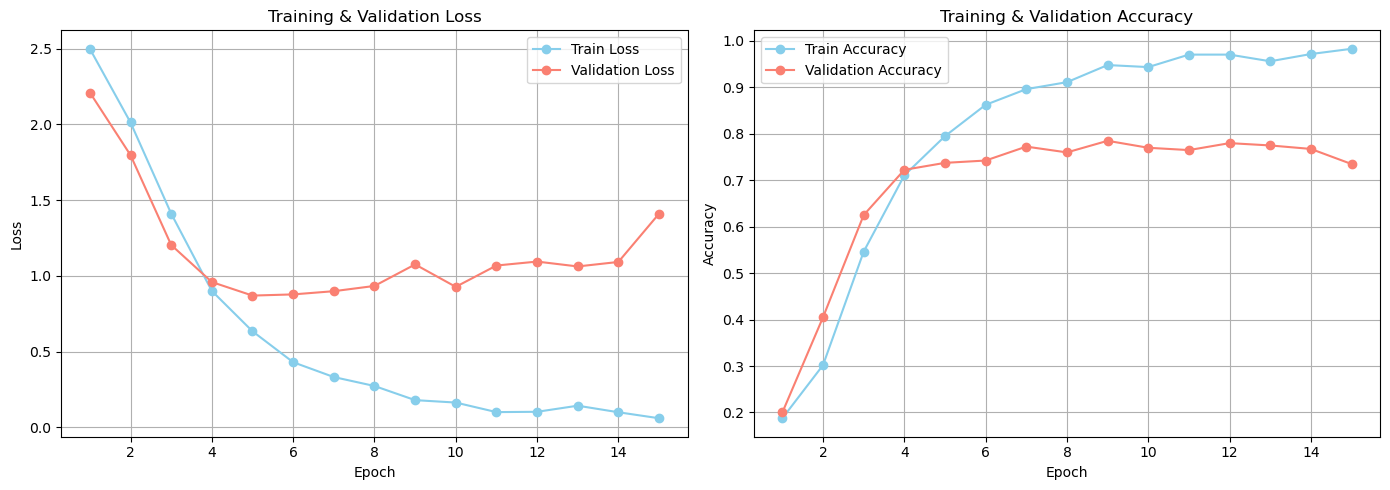

In [399]:
plotAccuracyAndLoss(history)

The training loss decreases steadily, and training accuracy improves consistently, indicating the model is learning effectively. However, after a few epochs, the validation loss starts increasing, and validation accuracy peaks before declining, suggesting overfitting. The model initially generalizes well but begins to memorize the training data, leading to poorer performance on unseen validation data.

In [400]:
evaluateWithTestSet(model, svhn_test_loader)

Test Accuracy: 71.40%


With a test accuracy of ~71%, the model shows signs of overfitting, as seen in the training and validation trends. While it achieves nearly 90% accuracy on the training data, its performance on the test set is significantly lower, indicating poor generalization.

## Exercise-6: CNN with SGD, MC Dropout, and Epistemic Uncertainty
### Q6.1 Report the plain test accuracy of the CNN trained with SGD (no MC Dropout).
We define a lightweight CNN for the SVHN dataset with two convolutional layers using ReLU activations and max-pooling. The flattened output is passed through a dense layer with 128 neurons and a dropout rate of 0.25, followed by a 10-neuron output layer for the SVHN classes. He normal initialization is applied to all convolutional and linear layers to improve convergence and training stability.

In [401]:
class SVHN_CNN_LITE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )   

        # Apply He normal initialization to all Linear layers
        for layer in list(self.features) + list(self.classifier):
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.features(x)    
        x = self.classifier(x) 
        return x


Next, we train the custom CNN model using the SGD optimizer with a learning rate of 0.01 and momentum of 0.9. The loss function is sparse categorical cross-entropy, and the training is run for 15 epochs without early stopping.

In [402]:
model = SVHN_CNN_LITE().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 15
patience = 15  # no early stopping

model, history = train_model(model, svhn_train_loader, svhn_val_loader, epochs, patience)

Epoch 1/15 | Train Loss: 2.4423, Acc: 0.1719 | Val Loss: 2.2159, Acc: 0.1925
Epoch 2/15 | Train Loss: 2.1399, Acc: 0.2338 | Val Loss: 2.0463, Acc: 0.2825
Epoch 3/15 | Train Loss: 1.8496, Acc: 0.3475 | Val Loss: 1.6441, Acc: 0.4675
Epoch 4/15 | Train Loss: 1.4913, Acc: 0.4913 | Val Loss: 1.3965, Acc: 0.5025
Epoch 5/15 | Train Loss: 1.2649, Acc: 0.5625 | Val Loss: 1.1876, Acc: 0.5925
Epoch 6/15 | Train Loss: 1.0239, Acc: 0.6550 | Val Loss: 1.0421, Acc: 0.6550
Epoch 7/15 | Train Loss: 0.8292, Acc: 0.7131 | Val Loss: 0.9430, Acc: 0.6675
Epoch 8/15 | Train Loss: 0.6902, Acc: 0.7650 | Val Loss: 0.8868, Acc: 0.7025
Epoch 9/15 | Train Loss: 0.6057, Acc: 0.8087 | Val Loss: 0.8276, Acc: 0.7300
Epoch 10/15 | Train Loss: 0.5052, Acc: 0.8394 | Val Loss: 0.8739, Acc: 0.7325
Epoch 11/15 | Train Loss: 0.4076, Acc: 0.8744 | Val Loss: 0.8274, Acc: 0.7575
Epoch 12/15 | Train Loss: 0.4038, Acc: 0.8650 | Val Loss: 0.8250, Acc: 0.7625
Epoch 13/15 | Train Loss: 0.3124, Acc: 0.8894 | Val Loss: 0.8986, Acc: 0.

We visualize training results using `plotAccuracyAndLoss(history)`, which shows loss and accuracy for both training and validation sets.

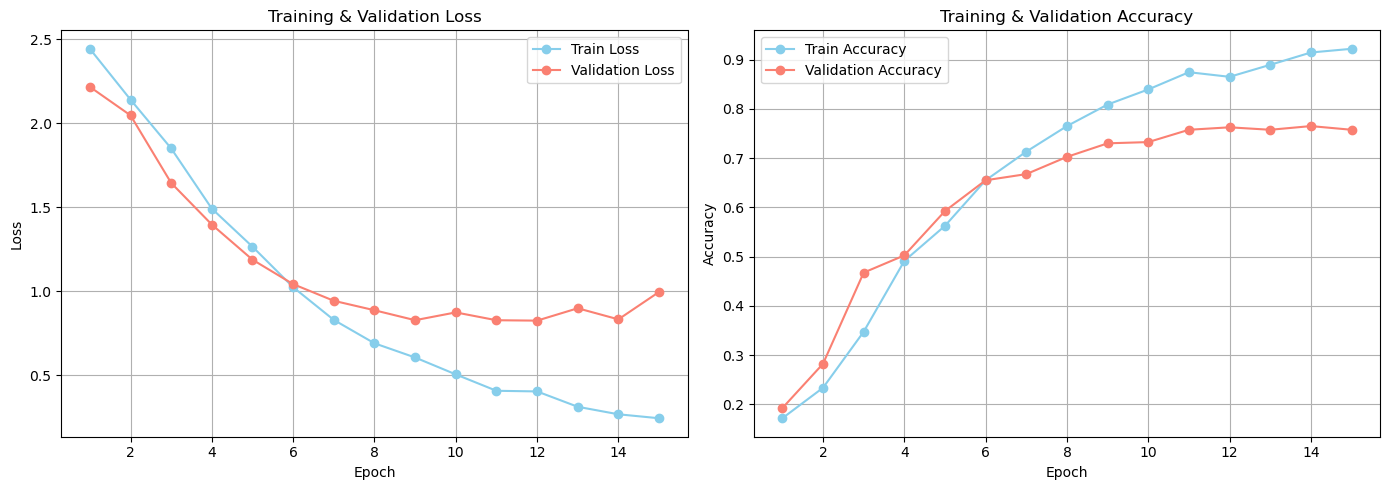

In [403]:
plotAccuracyAndLoss(history)

Training loss steadily decreases, showing effective learning, but validation loss plateaus and fluctuates after epoch 9, indicating possible overfitting. Training accuracy rises above 90%, while validation accuracy plateaus around 75% after epoch 12, highlighting the gap in generalization.

In [404]:
evaluateWithTestSet(model, svhn_test_loader)

Test Accuracy: 75.40%


The lightweight model achieves a final test accuracy of approximately 75%, measuring comparably with the more complex CNN architecture on the same dataset. This suggests that the simpler model strikes a better balance between capacity and generalization, making it more effective for this task despite having fewer parameters.



### Q6.2 Report the MC Dropout-enhanced accuracy (averaging 20 stochastic predictions).

In [405]:
mc_acc, mc_var = mcDropoutAccuracy(model, svhn_test_loader, n_samples=20)

Accuracy with Monte Carlo Dropout: 74.80%


This result is nearly identical to the baseline accuracy of the model, indicating that averaging multiple stochastic predictions does not substantially change overall predictive performance. However, it enables estimation of epistemic uncertainty, capturing how confident the model is in its predictions.

### Q6.3 Compute the average epistemic uncertainty (mean predictive variance) across all test samples. Report it as a deterministic number rounded to 3 decimal places.

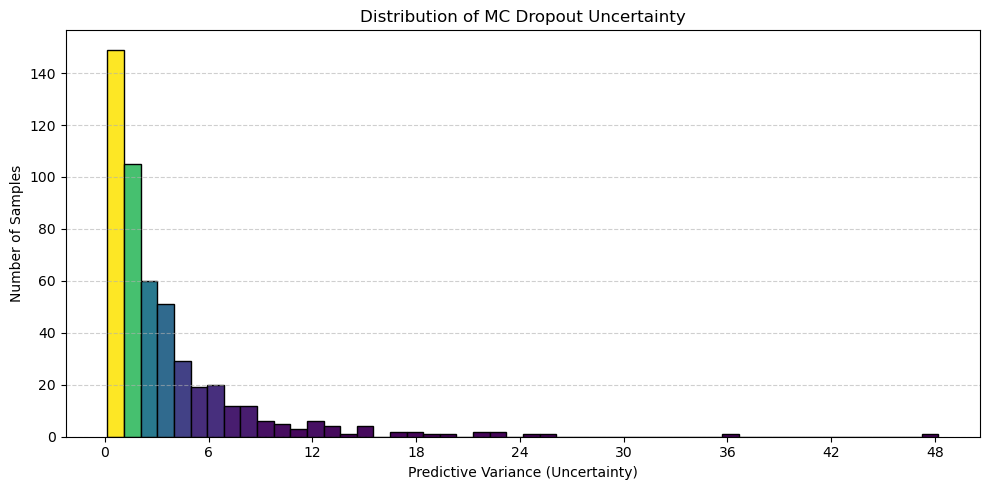

In [406]:
plotMcUncertainty(mc_var)

In [407]:
avg_epistemic_uncertainty = mc_var.mean().item()
print(f"Average epistemic uncertainty: {avg_epistemic_uncertainty:.3f}")

Average epistemic uncertainty: 3.631


The distribution of epistemic uncertainty shows that most test samples have low predictive variance, indicating high model confidence. However, a small subset of samples exhibits significantly higher uncertainty. This might be due to ambiguity or limited representation in the training data. The average epistemic uncertainty across the test set is ~3.6